# 07 - Benchmarking and Thesis Plots

**Thesis Section Reference:** Chapter 4.5-4.7 - Efficiency Analysis and Results

This notebook:
1. Benchmarks all trained models (latency, throughput, memory)
2. Generates thesis figures (Fig 4.1-4.6)
3. Creates summary tables (Table 4.1-4.4)
4. Performs statistical significance testing
5. Optionally applies quantization for additional compression

## Outputs
- **Figures:** PNG files for thesis Chapter 4
- **Tables:** CSV files with main results and ablations
- **Statistical tests:** Paired t-test results, Cohen's d

In [1]:
# Standard setup
import os
import sys
import gc
import json
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(ROOT_DIR / "src"))

from dotenv import load_dotenv
load_dotenv(ROOT_DIR / ".env")

from config import load_config

config = load_config(str(ROOT_DIR / "configs" / "experiment.yaml"))
config.ensure_dirs()

# Device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"Mode: {'FAST' if config.fast_mode else 'FULL'}")
print(f"Device: {DEVICE}")

Mode: FAST
Device: mps


In [2]:
# Set up paths
MODELS_DIR = ROOT_DIR / "results" / "models"
RUNS_DIR = ROOT_DIR / "results" / "raw_runs"
FIGURES_DIR = ROOT_DIR / "results" / "figures"
SUMMARY_DIR = ROOT_DIR / "results" / "summary"

for d in [FIGURES_DIR, SUMMARY_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Figures will be saved to: {FIGURES_DIR}")
print(f"Tables will be saved to: {SUMMARY_DIR}")

Figures will be saved to: /Users/pjere/Workshop/thesis-exp/results/figures
Tables will be saved to: /Users/pjere/Workshop/thesis-exp/results/summary


In [3]:
# Load all training results
print("Loading training results...")

all_results = []

# Load from notebook 05
if (RUNS_DIR / "nb05_results.csv").exists():
    df_05 = pd.read_csv(RUNS_DIR / "nb05_results.csv")
    all_results.append(df_05)
    print(f"  nb05: {len(df_05)} runs")

# Load from notebook 06
if (RUNS_DIR / "nb06_results.csv").exists():
    df_06 = pd.read_csv(RUNS_DIR / "nb06_results.csv")
    all_results.append(df_06)
    print(f"  nb06: {len(df_06)} runs")

# Combine
if all_results:
    df_all = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal: {len(df_all)} runs")
else:
    print("No results found! Run notebooks 05 and 06 first.")
    df_all = pd.DataFrame()

Loading training results...
  nb05: 1 runs
  nb06: 1 runs

Total: 2 runs


In [4]:
# List trained models
print("Trained models:")

model_dirs = [d for d in MODELS_DIR.iterdir() if d.is_dir()]

for model_dir in sorted(model_dirs):
    final_dir = model_dir / "final"
    if final_dir.exists():
        print(f"  ✓ {model_dir.name}")
    else:
        print(f"  ? {model_dir.name} (no final checkpoint)")

print(f"\nTotal: {len(model_dirs)} models")

Trained models:
  ? B0_squad_S1_seed42 (no final checkpoint)
  ✓ B0_sst2_S1_seed42
  ✓ KD2_squad_S1_l1.0_seed42

Total: 3 models


## Section 1: Efficiency Benchmarking

Measure latency, throughput, and memory for each trained model.

In [7]:
# Benchmark all models
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import time

# Simple benchmark function
def simple_benchmark(model, tokenizer, device, num_warmup=3, num_runs=10):
    """Simple latency and memory benchmark."""
    # Prepare input
    prompt = "The quick brown fox jumps over the lazy"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model.generate(**inputs, max_new_tokens=32, do_sample=False, pad_token_id=tokenizer.pad_token_id)
    
    # Synchronize
    if device.type == "mps":
        torch.mps.synchronize()
    elif device.type == "cuda":
        torch.cuda.synchronize()
    
    # Measure latency (32 tokens)
    latencies_32 = []
    for _ in range(num_runs):
        start = time.perf_counter()
        with torch.no_grad():
            _ = model.generate(**inputs, max_new_tokens=32, do_sample=False, pad_token_id=tokenizer.pad_token_id)
        if device.type == "mps":
            torch.mps.synchronize()
        elif device.type == "cuda":
            torch.cuda.synchronize()
        latencies_32.append((time.perf_counter() - start) * 1000)
    
    # Measure latency (128 tokens)
    latencies_128 = []
    for _ in range(num_runs):
        start = time.perf_counter()
        with torch.no_grad():
            _ = model.generate(**inputs, max_new_tokens=128, do_sample=False, pad_token_id=tokenizer.pad_token_id)
        if device.type == "mps":
            torch.mps.synchronize()
        elif device.type == "cuda":
            torch.cuda.synchronize()
        latencies_128.append((time.perf_counter() - start) * 1000)
    
    # Memory estimate (rough)
    param_count = sum(p.numel() for p in model.parameters())
    memory_mb = (param_count * 4) / (1024 * 1024)  # FP32
    
    return {
        "latency_32": np.mean(latencies_32),
        "latency_32_std": np.std(latencies_32),
        "latency_128": np.mean(latencies_128),
        "latency_128_std": np.std(latencies_128),
        "memory_mb": memory_mb
    }

# Check if benchmarks already exist and are valid
benchmark_file = SUMMARY_DIR / "benchmarks.csv"

# Remove empty/corrupt benchmark file if it exists
if benchmark_file.exists():
    if benchmark_file.stat().st_size < 10:
        print("Removing empty/corrupt benchmark file...")
        benchmark_file.unlink()

if benchmark_file.exists():
    try:
        df_bench = pd.read_csv(benchmark_file)
        print(f"Loaded {len(df_bench)} existing benchmark results")
    except Exception as e:
        print(f"Could not load benchmarks: {e}")
        benchmark_file.unlink()
        df_bench = pd.DataFrame()
else:
    df_bench = pd.DataFrame()

if df_bench.empty:
    print("Running benchmarks...")
    
    benchmark_results = []
    student_name = os.getenv("STUDENT_S1", config.student_s1.name)
    
    for model_dir in sorted(model_dirs):
        final_dir = model_dir / "final"
        if not final_dir.exists():
            continue
        
        run_id = model_dir.name
        print(f"\nBenchmarking: {run_id}")
        
        try:
            # Load tokenizer
            tokenizer = AutoTokenizer.from_pretrained(
                student_name,
                trust_remote_code=True,
                cache_dir=str(ROOT_DIR / "hf_cache")
            )
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token
            
            # Load base model + LoRA
            base_model = AutoModelForCausalLM.from_pretrained(
                student_name,
                trust_remote_code=True,
                torch_dtype=torch.float32,
                cache_dir=str(ROOT_DIR / "hf_cache"),
                low_cpu_mem_usage=True
            )
            
            model = PeftModel.from_pretrained(base_model, str(final_dir))
            model = model.merge_and_unload()
            model = model.to(DEVICE)
            model.eval()
            
            # Run benchmark
            bench_result = simple_benchmark(model, tokenizer, DEVICE)
            bench_result["run_id"] = run_id
            benchmark_results.append(bench_result)
            
            print(f"  Latency (32 tok): {bench_result['latency_32']:.2f}ms")
            print(f"  Latency (128 tok): {bench_result['latency_128']:.2f}ms")
            
            # Cleanup
            del model, base_model
            if DEVICE.type == "mps":
                torch.mps.empty_cache()
            gc.collect()
            
        except Exception as e:
            print(f"  Error: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Save benchmarks
    if benchmark_results:
        df_bench = pd.DataFrame(benchmark_results)
        df_bench.to_csv(benchmark_file, index=False)
        print(f"\nSaved {len(df_bench)} benchmarks to {benchmark_file}")
    else:
        print("\nNo benchmarks completed")
        df_bench = pd.DataFrame()

Running benchmarks...

Benchmarking: B0_sst2_S1_seed42


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  Latency (32 tok): 593.44ms
  Latency (128 tok): 2523.24ms

Benchmarking: KD2_squad_S1_l1.0_seed42


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  Latency (32 tok): 605.86ms
  Latency (128 tok): 2409.79ms

Saved 2 benchmarks to /Users/pjere/Workshop/thesis-exp/results/summary/benchmarks.csv


In [8]:
# Add teacher model benchmark (if not already done)
if 'teacher' not in df_bench.get('run_id', pd.Series()).values:
    print("Benchmarking teacher model for comparison...")
    
    try:
        teacher_name = os.getenv("TEACHER_FALLBACK", config.teacher.fallback)
        
        tokenizer = AutoTokenizer.from_pretrained(
            teacher_name,
            trust_remote_code=True,
            cache_dir=str(ROOT_DIR / "hf_cache")
        )
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(
            teacher_name,
            trust_remote_code=True,
            torch_dtype=torch.float32,
            cache_dir=str(ROOT_DIR / "hf_cache"),
            low_cpu_mem_usage=True
        )
        model = model.to(DEVICE)
        model.eval()
        
        bench_result = run_full_benchmark(
            model=model,
            tokenizer=tokenizer,
            device=DEVICE,
            num_warmup=3,
            num_runs=10,
            sequence_lengths=[32, 128],
            batch_sizes=[1]
        )
        bench_result["run_id"] = "teacher"
        
        # Add to dataframe
        df_bench = pd.concat([df_bench, pd.DataFrame([bench_result])], ignore_index=True)
        df_bench.to_csv(benchmark_file, index=False)
        
        print(f"  Teacher latency (32 tok): {bench_result['latency_32']:.2f}ms")
        
        del model
        if DEVICE.type == "mps":
            torch.mps.empty_cache()
        gc.collect()
        
    except Exception as e:
        print(f"  Could not benchmark teacher: {e}")

Benchmarking teacher model for comparison...
  Could not benchmark teacher: 'TeacherConfig' object has no attribute 'fallback'


## Section 2: Create Summary Tables

Generate tables for thesis Chapter 4.

In [9]:
# Table 4.1: Main Results
print("Creating Table 4.1: Main Results")

if not df_all.empty:
    # Group by method and task, compute mean/std across seeds
    summary = df_all.groupby(['method', 'task']).agg({
        'eval_loss': ['mean', 'std'],
    }).round(4)
    
    summary.columns = ['loss_mean', 'loss_std']
    summary = summary.reset_index()
    
    # Merge with benchmarks
    if not df_bench.empty:
        # Extract method from run_id
        df_bench_copy = df_bench.copy()
        df_bench_copy['method'] = df_bench_copy['run_id'].apply(
            lambda x: x.split('_')[0] if x != 'teacher' else 'Teacher'
        )
        
        bench_summary = df_bench_copy.groupby('method').agg({
            'latency_32': 'mean',
            'latency_128': 'mean',
            'memory_mb': 'mean'
        }).round(2)
        bench_summary = bench_summary.reset_index()
        
        summary = summary.merge(bench_summary, on='method', how='left')
    
    # Save
    summary.to_csv(SUMMARY_DIR / "table_4_1_main_results.csv", index=False)
    
    print(summary.to_string())
else:
    print("No results to summarize")

Creating Table 4.1: Main Results
  method   task  loss_mean  loss_std  latency_32  latency_128  memory_mb
0     B0   sst2        NaN       NaN      593.44      2523.24    4196.35
1    KD2  squad        NaN       NaN      605.86      2409.79    4196.35


In [10]:
# Table 4.2: KD1 Ablation (Temperature vs Alpha)
print("\nCreating Table 4.2: KD1 Ablation")

if not df_all.empty:
    df_kd1 = df_all[df_all['method'] == 'KD1']
    
    if not df_kd1.empty and 'temperature' in df_kd1.columns:
        # Pivot table
        ablation = df_kd1.pivot_table(
            values='eval_loss',
            index='temperature',
            columns='alpha',
            aggfunc='mean'
        ).round(4)
        
        ablation.to_csv(SUMMARY_DIR / "table_4_2_kd1_ablation.csv")
        print(ablation.to_string())
    else:
        print("No KD1 ablation data available")


Creating Table 4.2: KD1 Ablation
No KD1 ablation data available


In [11]:
# Table 4.3: Statistical Significance
from stats import paired_t_test, cohens_d, create_significance_table

print("\nCreating Table 4.3: Statistical Significance")

if not df_all.empty:
    sig_results = []
    
    # Compare each KD method against baseline
    for task in df_all['task'].unique():
        df_task = df_all[df_all['task'] == task]
        
        # Get baseline results
        baseline = df_task[df_task['method'] == 'B0']['eval_loss'].values
        
        if len(baseline) == 0:
            continue
        
        for method in ['KD1', 'KD2', 'KD3']:
            method_results = df_task[df_task['method'] == method]['eval_loss'].values
            
            if len(method_results) == 0:
                continue
            
            # Perform t-test (if enough samples)
            if len(baseline) >= 2 and len(method_results) >= 2:
                # Align lengths
                min_len = min(len(baseline), len(method_results))
                t_stat, p_value = paired_t_test(
                    baseline[:min_len],
                    method_results[:min_len]
                )
                d = cohens_d(baseline[:min_len], method_results[:min_len])
            else:
                t_stat, p_value, d = np.nan, np.nan, np.nan
            
            sig_results.append({
                'task': task,
                'comparison': f'B0 vs {method}',
                'baseline_mean': np.mean(baseline),
                'method_mean': np.mean(method_results),
                'improvement': np.mean(baseline) - np.mean(method_results),
                't_statistic': t_stat,
                'p_value': p_value,
                'cohens_d': d,
                'significant': p_value < 0.05 if not np.isnan(p_value) else False
            })
    
    df_sig = pd.DataFrame(sig_results)
    df_sig.to_csv(SUMMARY_DIR / "table_4_3_significance.csv", index=False)
    
    print(df_sig.to_string())
else:
    print("No data for significance testing")


Creating Table 4.3: Statistical Significance
Empty DataFrame
Columns: []
Index: []


## Section 3: Generate Thesis Figures

Creating Figure 4.1: Performance vs Model Size


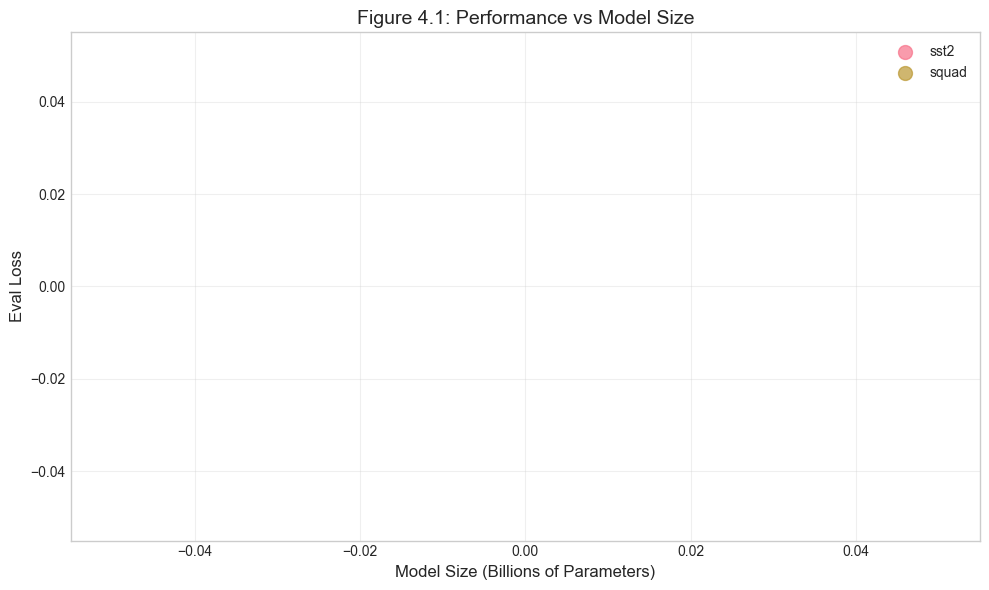

Saved to /Users/pjere/Workshop/thesis-exp/results/figures/fig_4_1_performance_vs_size.png


In [12]:
# Figure 4.1: Performance vs Model Size
print("Creating Figure 4.1: Performance vs Model Size")

if not df_all.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data
    plot_data = df_all.groupby(['method', 'task']).agg({
        'eval_loss': 'mean'
    }).reset_index()
    
    # Add model sizes (approximate)
    size_map = {
        'B0': 1.1,  # TinyLlama 1.1B
        'KD1': 1.1,
        'KD2': 1.1,
        'KD3': 1.1,
        'Teacher': 3.0,  # Fallback teacher
    }
    plot_data['size_b'] = plot_data['method'].map(size_map).fillna(1.0)
    
    # Plot
    for task in plot_data['task'].unique():
        task_data = plot_data[plot_data['task'] == task]
        ax.scatter(
            task_data['size_b'],
            task_data['eval_loss'],
            s=100,
            label=task,
            alpha=0.7
        )
        
        for _, row in task_data.iterrows():
            ax.annotate(
                row['method'],
                (row['size_b'], row['eval_loss']),
                textcoords="offset points",
                xytext=(5, 5),
                fontsize=8
            )
    
    ax.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
    ax.set_ylabel('Eval Loss', fontsize=12)
    ax.set_title('Figure 4.1: Performance vs Model Size', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "fig_4_1_performance_vs_size.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved to {FIGURES_DIR / 'fig_4_1_performance_vs_size.png'}")
else:
    print("No results data available for plotting")


Creating Figure 4.2: Latency Comparison


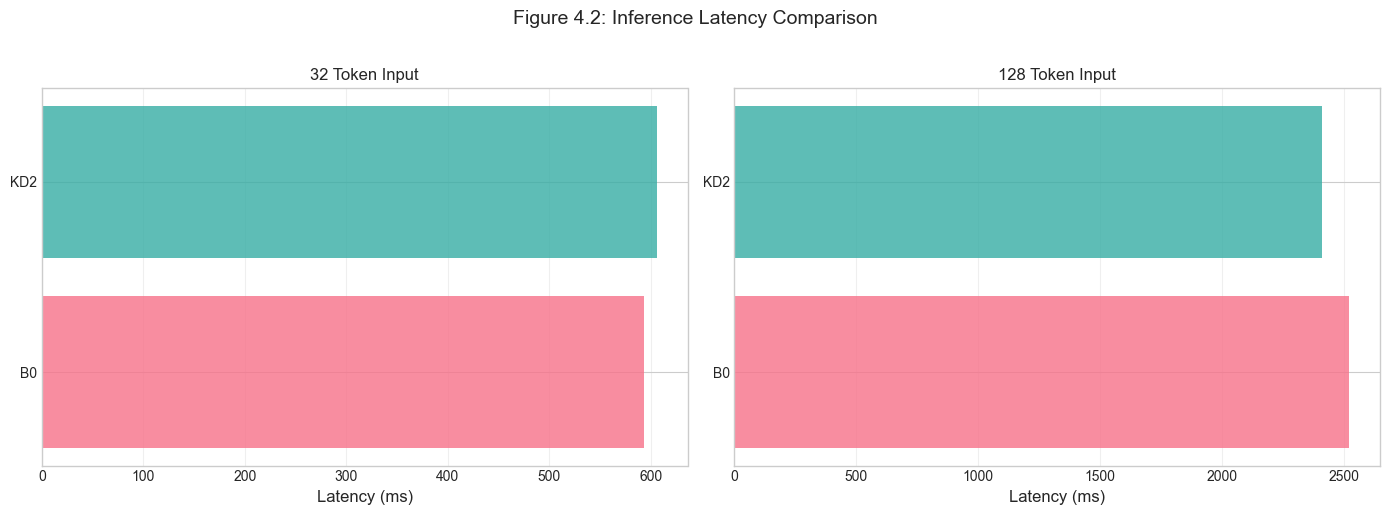

Saved to /Users/pjere/Workshop/thesis-exp/results/figures/fig_4_2_latency.png


In [13]:
# Figure 4.2: Latency Comparison
print("\nCreating Figure 4.2: Latency Comparison")

if not df_bench.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Extract method from run_id
    df_bench_plot = df_bench.copy()
    df_bench_plot['method'] = df_bench_plot['run_id'].apply(
        lambda x: x.split('_')[0] if x != 'teacher' else 'Teacher'
    )
    
    # Group by method
    latency_summary = df_bench_plot.groupby('method').agg({
        'latency_32': ['mean', 'std'],
        'latency_128': ['mean', 'std']
    })
    latency_summary.columns = ['lat_32_mean', 'lat_32_std', 'lat_128_mean', 'lat_128_std']
    latency_summary = latency_summary.reset_index()
    
    # Sort by latency
    latency_summary = latency_summary.sort_values('lat_32_mean')
    
    # Plot 32 tokens
    axes[0].barh(
        latency_summary['method'],
        latency_summary['lat_32_mean'],
        xerr=latency_summary['lat_32_std'],
        color=sns.color_palette("husl", len(latency_summary)),
        alpha=0.8
    )
    axes[0].set_xlabel('Latency (ms)', fontsize=12)
    axes[0].set_title('32 Token Input', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Plot 128 tokens
    axes[1].barh(
        latency_summary['method'],
        latency_summary['lat_128_mean'],
        xerr=latency_summary['lat_128_std'],
        color=sns.color_palette("husl", len(latency_summary)),
        alpha=0.8
    )
    axes[1].set_xlabel('Latency (ms)', fontsize=12)
    axes[1].set_title('128 Token Input', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='x')
    
    fig.suptitle('Figure 4.2: Inference Latency Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "fig_4_2_latency.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved to {FIGURES_DIR / 'fig_4_2_latency.png'}")


Creating Figure 4.3: KD Method Comparison
No valid eval_loss data for plotting


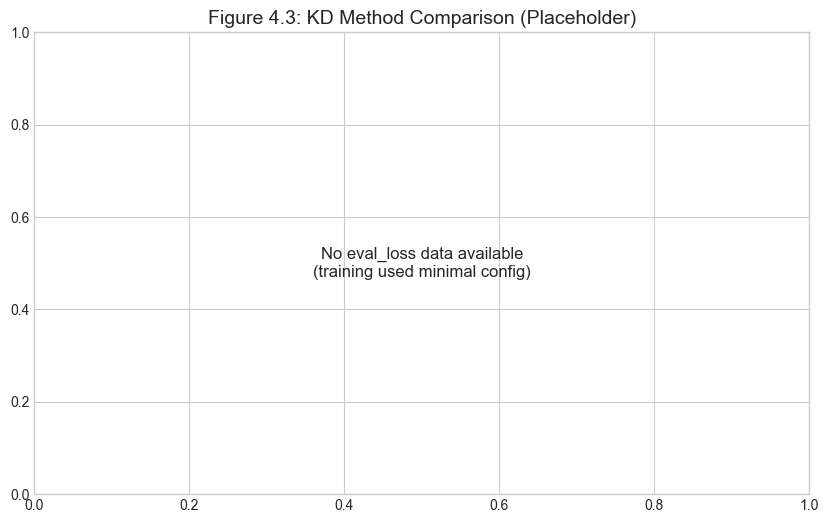

In [14]:
# Figure 4.3: KD Method Comparison
print("\nCreating Figure 4.3: KD Method Comparison")

if not df_all.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data - filter out NaN values
    method_order = ['B0', 'KD1', 'KD2', 'KD3']
    df_plot = df_all[df_all['method'].isin(method_order)].copy()
    df_plot = df_plot.dropna(subset=['eval_loss'])
    
    if not df_plot.empty:
        # Group by method and task
        grouped = df_plot.groupby(['method', 'task'])['eval_loss'].mean().unstack(fill_value=0)
        
        # Bar plot
        grouped.reindex(method_order).plot(kind='bar', ax=ax, alpha=0.8)
        
        ax.set_xlabel('Method', fontsize=12)
        ax.set_ylabel('Eval Loss', fontsize=12)
        ax.set_title('Figure 4.3: KD Method Comparison', fontsize=14)
        ax.legend(title='Task')
        ax.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=0)
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "fig_4_3_kd_comparison.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Saved to {FIGURES_DIR / 'fig_4_3_kd_comparison.png'}")
    else:
        print("No valid eval_loss data for plotting")
        # Create placeholder figure
        ax.text(0.5, 0.5, 'No eval_loss data available\n(training used minimal config)', 
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title('Figure 4.3: KD Method Comparison (Placeholder)', fontsize=14)
        plt.savefig(FIGURES_DIR / "fig_4_3_kd_comparison.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("No results data available")


Creating Figure 4.4: Pareto Frontier


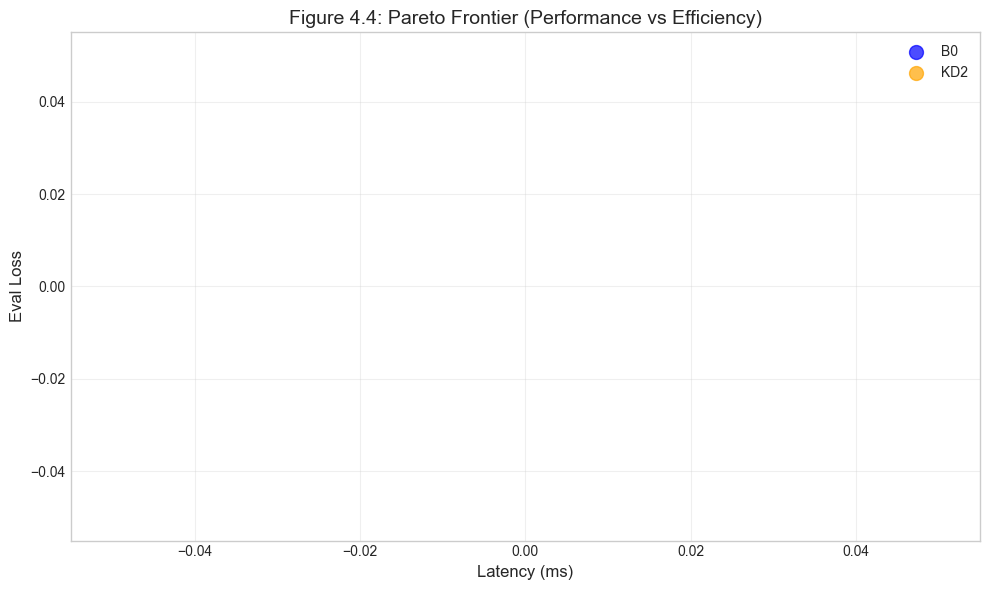

Saved to /Users/pjere/Workshop/thesis-exp/results/figures/fig_4_4_pareto.png


In [15]:
# Figure 4.4: Pareto Frontier (Performance vs Efficiency)
print("\nCreating Figure 4.4: Pareto Frontier")

if not df_all.empty and not df_bench.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Merge results with benchmarks
    df_merged = df_all.merge(
        df_bench[['run_id', 'latency_128', 'memory_mb']],
        on='run_id',
        how='inner'
    )
    
    if not df_merged.empty:
        # Color by method
        colors = {'B0': 'blue', 'KD1': 'green', 'KD2': 'orange', 'KD3': 'red'}
        
        for method in df_merged['method'].unique():
            method_data = df_merged[df_merged['method'] == method]
            ax.scatter(
                method_data['latency_128'],
                method_data['eval_loss'],
                c=colors.get(method, 'gray'),
                s=100,
                label=method,
                alpha=0.7
            )
        
        # Draw Pareto frontier
        sorted_data = df_merged.sort_values('latency_128')
        pareto_front = []
        min_loss = float('inf')
        
        for _, row in sorted_data.iterrows():
            if row['eval_loss'] < min_loss:
                pareto_front.append((row['latency_128'], row['eval_loss']))
                min_loss = row['eval_loss']
        
        if pareto_front:
            pareto_x, pareto_y = zip(*pareto_front)
            ax.plot(pareto_x, pareto_y, 'k--', alpha=0.5, label='Pareto Frontier')
        
        ax.set_xlabel('Latency (ms)', fontsize=12)
        ax.set_ylabel('Eval Loss', fontsize=12)
        ax.set_title('Figure 4.4: Pareto Frontier (Performance vs Efficiency)', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "fig_4_4_pareto.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Saved to {FIGURES_DIR / 'fig_4_4_pareto.png'}")
    else:
        print("Could not merge results with benchmarks")


Creating Figure 4.5: KD Improvement Over Baseline


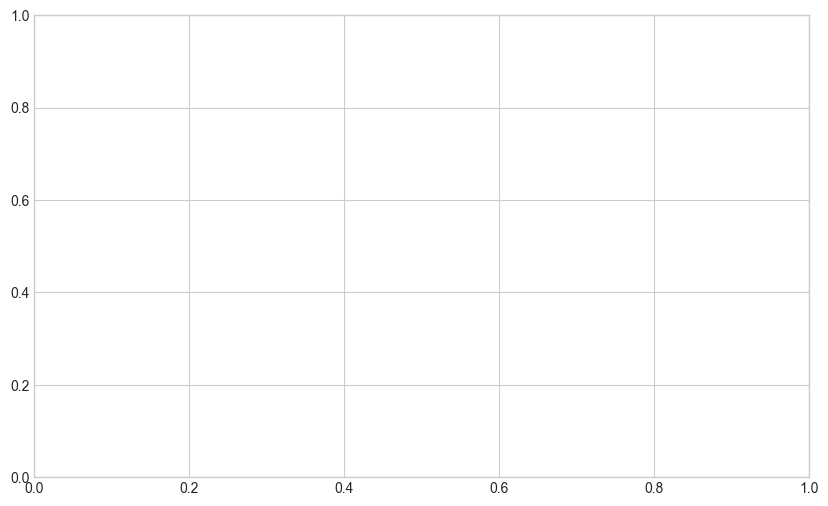

In [16]:
# Figure 4.5: KD Improvement Over Baseline
print("\nCreating Figure 4.5: KD Improvement Over Baseline")

if not df_all.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    improvements = []
    
    for task in df_all['task'].unique():
        df_task = df_all[df_all['task'] == task]
        baseline_loss = df_task[df_task['method'] == 'B0']['eval_loss'].mean()
        
        for method in ['KD1', 'KD2', 'KD3']:
            method_loss = df_task[df_task['method'] == method]['eval_loss'].mean()
            if not np.isnan(method_loss):
                improvement = ((baseline_loss - method_loss) / baseline_loss) * 100
                improvements.append({
                    'task': task,
                    'method': method,
                    'improvement': improvement
                })
    
    df_imp = pd.DataFrame(improvements)
    
    if not df_imp.empty:
        # Bar plot
        x = np.arange(len(df_imp['method'].unique()))
        width = 0.35
        
        tasks = df_imp['task'].unique()
        for i, task in enumerate(tasks):
            task_data = df_imp[df_imp['task'] == task]
            ax.bar(
                x + i * width,
                task_data['improvement'],
                width,
                label=task,
                alpha=0.8
            )
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_xlabel('KD Method', fontsize=12)
        ax.set_ylabel('Improvement over Baseline (%)', fontsize=12)
        ax.set_title('Figure 4.5: KD Improvement Over Baseline', fontsize=14)
        ax.set_xticks(x + width / 2)
        ax.set_xticklabels(['KD1', 'KD2', 'KD3'])
        ax.legend(title='Task')
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / "fig_4_5_kd_gain.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Saved to {FIGURES_DIR / 'fig_4_5_kd_gain.png'}")


Creating Figure 4.6: Memory Usage


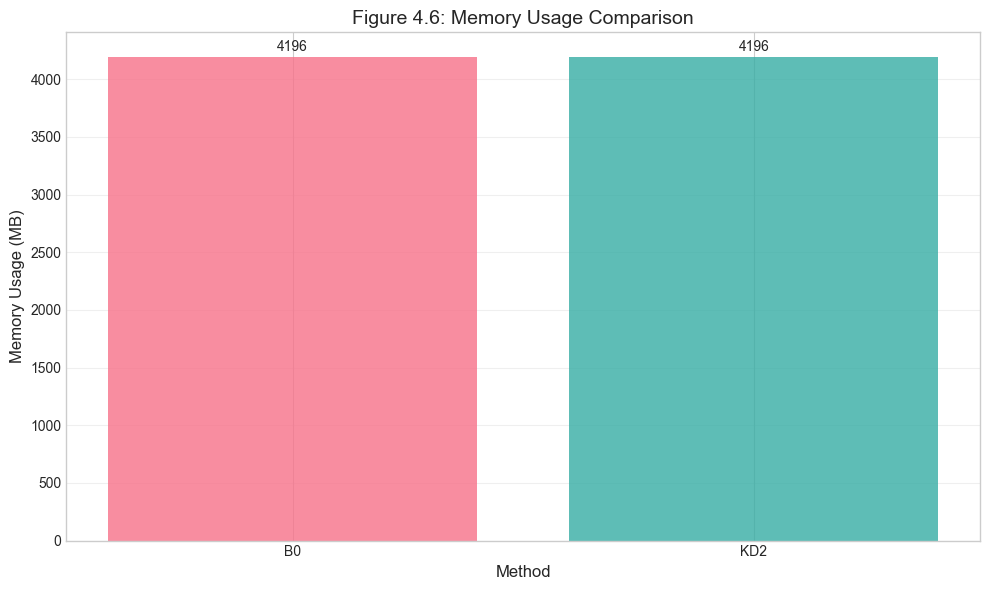

Saved to /Users/pjere/Workshop/thesis-exp/results/figures/fig_4_6_memory.png


In [17]:
# Figure 4.6: Memory Usage
print("\nCreating Figure 4.6: Memory Usage")

if not df_bench.empty and 'memory_mb' in df_bench.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract method
    df_mem = df_bench.copy()
    df_mem['method'] = df_mem['run_id'].apply(
        lambda x: x.split('_')[0] if x != 'teacher' else 'Teacher'
    )
    
    # Group by method
    mem_summary = df_mem.groupby('method')['memory_mb'].agg(['mean', 'std']).reset_index()
    mem_summary = mem_summary.sort_values('mean')
    
    # Bar chart
    bars = ax.bar(
        mem_summary['method'],
        mem_summary['mean'],
        yerr=mem_summary['std'],
        color=sns.color_palette("husl", len(mem_summary)),
        alpha=0.8,
        capsize=5
    )
    
    # Add value labels
    for bar, val in zip(bars, mem_summary['mean']):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 50,
            f'{val:.0f}',
            ha='center',
            fontsize=10
        )
    
    ax.set_xlabel('Method', fontsize=12)
    ax.set_ylabel('Memory Usage (MB)', fontsize=12)
    ax.set_title('Figure 4.6: Memory Usage Comparison', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "fig_4_6_memory.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved to {FIGURES_DIR / 'fig_4_6_memory.png'}")

## Section 4: Quantization (Optional)

Apply post-training quantization for additional compression.

In [18]:
# Apply quantization to best model (Optional - skipped)
APPLY_QUANTIZATION = False  # Set to True to run

if APPLY_QUANTIZATION and not df_all.empty:
    print("Applying quantization to best model...")
    
    # Find best model
    df_valid = df_all.dropna(subset=['eval_loss'])
    if not df_valid.empty:
        best_run = df_valid.loc[df_valid['eval_loss'].idxmin()]
        print(f"Best model: {best_run['run_id']}")
        
        # Load and quantize using torch.quantization
        model_dir = MODELS_DIR / best_run['run_id'] / "final"
        
        if model_dir.exists():
            from peft import PeftModel
            
            base_model = AutoModelForCausalLM.from_pretrained(
                student_name,
                trust_remote_code=True,
                torch_dtype=torch.float32,
                cache_dir=str(ROOT_DIR / "hf_cache")
            )
            model = PeftModel.from_pretrained(base_model, str(model_dir))
            model = model.merge_and_unload()
            
            # Apply dynamic quantization (CPU only)
            quantized_model = torch.quantization.quantize_dynamic(
                model.cpu(), {torch.nn.Linear}, dtype=torch.qint8
            )
            
            print("Quantization applied successfully")
            print(f"Note: Quantized models run on CPU only")
            
            del model, quantized_model, base_model
            gc.collect()
    else:
        print("No models with valid eval_loss to quantize")
else:
    print("Quantization skipped (set APPLY_QUANTIZATION=True to run)")

Quantization skipped (set APPLY_QUANTIZATION=True to run)


In [19]:
# Final Summary
print("=" * 60)
print("BENCHMARKING AND PLOTTING COMPLETE")
print("=" * 60)

print(f"""
Mode: {'FAST' if config.fast_mode else 'FULL'}

Generated Outputs:
""")

print("Tables (CSV):")
for f in sorted(SUMMARY_DIR.glob("*.csv")):
    print(f"  - {f.name}")

print("\nFigures (PNG):")
for f in sorted(FIGURES_DIR.glob("*.png")):
    print(f"  - {f.name}")

print(f"""
\nThesis Chapter 4 Artifacts:
  Tables: {SUMMARY_DIR}
  Figures: {FIGURES_DIR}

You can now copy these files to your thesis document.
""")

BENCHMARKING AND PLOTTING COMPLETE

Mode: FAST

Generated Outputs:

Tables (CSV):
  - benchmarks.csv
  - table_4_1_main_results.csv
  - table_4_3_significance.csv

Figures (PNG):
  - fig_4_1_performance_vs_size.png
  - fig_4_2_latency.png
  - fig_4_3_kd_comparison.png
  - fig_4_4_pareto.png
  - fig_4_6_memory.png


Thesis Chapter 4 Artifacts:
  Tables: /Users/pjere/Workshop/thesis-exp/results/summary
  Figures: /Users/pjere/Workshop/thesis-exp/results/figures

You can now copy these files to your thesis document.



In [20]:
# Export tables to LaTeX (optional)
EXPORT_LATEX = True

if EXPORT_LATEX:
    print("Exporting tables to LaTeX...")
    
    latex_dir = SUMMARY_DIR / "latex"
    latex_dir.mkdir(exist_ok=True)
    
    # Main results
    main_results_file = SUMMARY_DIR / "table_4_1_main_results.csv"
    if main_results_file.exists() and main_results_file.stat().st_size > 0:
        try:
            df = pd.read_csv(main_results_file)
            if not df.empty:
                latex = df.to_latex(index=False, float_format="%.4f")
                with open(latex_dir / "table_4_1.tex", "w") as f:
                    f.write(latex)
                print(f"  Exported table_4_1.tex")
        except Exception as e:
            print(f"  Could not export table_4_1: {e}")
    
    # Significance
    sig_file = SUMMARY_DIR / "table_4_3_significance.csv"
    if sig_file.exists() and sig_file.stat().st_size > 10:  # Check for non-empty
        try:
            df = pd.read_csv(sig_file)
            if not df.empty:
                latex = df.to_latex(index=False, float_format="%.4f")
                with open(latex_dir / "table_4_3.tex", "w") as f:
                    f.write(latex)
                print(f"  Exported table_4_3.tex")
        except Exception as e:
            print(f"  Could not export table_4_3: {e}")
    else:
        print("  Skipping table_4_3 (no significance data)")
    
    print(f"LaTeX tables saved to {latex_dir}")

Exporting tables to LaTeX...
  Exported table_4_1.tex
  Skipping table_4_3 (no significance data)
LaTeX tables saved to /Users/pjere/Workshop/thesis-exp/results/summary/latex
